In [19]:
# Setup & imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
# %matplotlib inline

print("networkx version:", nx.__version__)

networkx version: 3.5


## 1) Load data


In [20]:
# Load SNAP Facebook combined dataset (edge list)
# The file is hosted at: https://snap.stanford.edu/data/facebook_combined.txt.gz
# If you have a local CSV, replace this section and use pd.read_csv('your.csv')

try:
    url = "https://snap.stanford.edu/data/facebook_combined.txt.gz"
    fb_edges = pd.read_csv(url, compression='gzip', sep=' ', header=None, names=['u','v'])
    print("Loaded Facebook edge list:", fb_edges.shape)
except Exception as e:
    print("Could not fetch remote dataset (network may be blocked).")
    print("Error:", e)
    # create a small synthetic fallback
    fb_edges = pd.DataFrame({'u':[0,0,1,2,3,4,4,5],'v':[1,2,2,3,4,5,6,6]})
    print("Using fallback synthetic edges:", fb_edges.shape)

# Build an undirected graph
G = nx.from_pandas_edgelist(fb_edges, source='u', target='v')
print(f"Graph built — nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")

Loaded Facebook edge list: (88234, 2)
Graph built — nodes: 4039, edges: 88234


## 2) Basic visualization


Visualizing subgraph with 1000 nodes, 4596 edges


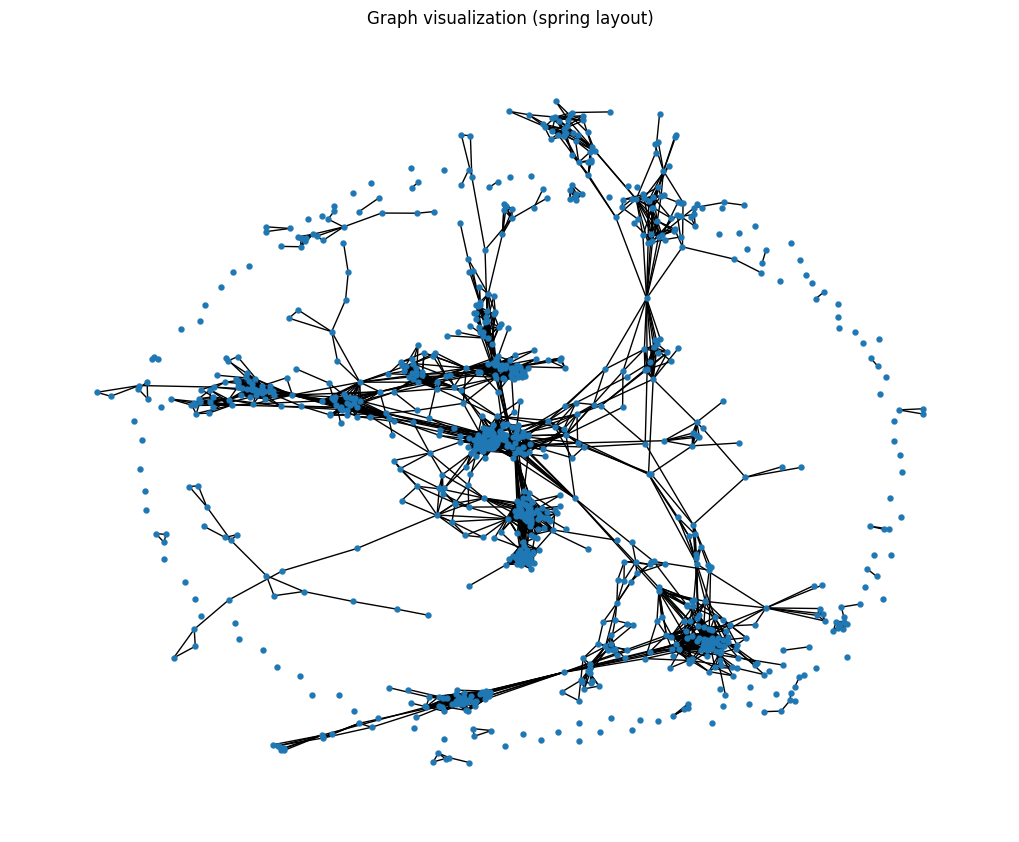

In [21]:
# For large graphs, sample nodes for visualization
n_nodes = G.number_of_nodes()
sample_size = 1000

if n_nodes > sample_size:
    # sample subgraph
    sample_nodes = list(np.random.choice(list(G.nodes()), size=sample_size, replace=False))
    G_vis = G.subgraph(sample_nodes).copy()
    print(f"Visualizing subgraph with {G_vis.number_of_nodes()} nodes, {G_vis.number_of_edges()} edges")
else:
    G_vis = G

pos = nx.spring_layout(G_vis, seed=1721, iterations=50)
plt.figure(figsize=(10,8))
nx.draw(G_vis, pos=pos, node_size=20, linewidths=0.1, with_labels=False)
plt.title("Graph visualization (spring layout)")
plt.axis('off')
plt.show()

## 3) Basic topological metrics

Compute degree statistics, density, connected components, average shortest path length (if feasible).

In [22]:
# Basic metrics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)
degrees = [d for _, d in G.degree()]
avg_degree = np.mean(degrees)
median_degree = np.median(degrees)
num_comp = nx.number_connected_components(G)

print("Nodes:", num_nodes)
print("Edges:", num_edges)
print("Density:", density)
print("Avg degree:", avg_degree)
print("Median degree:", median_degree)
print("Connected components:", num_comp)

# Largest connected component (LCC)
if num_comp > 1:
    comps = sorted(nx.connected_components(G), key=len, reverse=True)
    LCC = G.subgraph(comps[0]).copy()
    print("LCC nodes:", LCC.number_of_nodes(), "LCC edges:", LCC.number_of_edges())
else:
    LCC = G

Nodes: 4039
Edges: 88234
Density: 0.010819963503439287
Avg degree: 43.69101262688784
Median degree: 25.0
Connected components: 1


In [23]:
# Compute distances and diameter on the LCC if reasonably sized
max_nodes_for_all_pairs = 5000
if LCC.number_of_nodes() <= max_nodes_for_all_pairs:
    # all-pairs shortest path lengths
    spl = dict(nx.all_pairs_shortest_path_length(LCC))
    # diameter
    ecc = {n: max(d.values()) for n, d in spl.items()}
    diameter = max(ecc.values())
    avg_path_len = np.mean([np.mean(list(d.values())) for d in spl.values()])
    print("Diameter (LCC):", diameter)
    print("Average shortest path length (LCC):", avg_path_len)
else:
    print("LCC too large for all-pairs shortest paths (>", max_nodes_for_all_pairs, "nodes). Skipping.")

Diameter (LCC): 8
Average shortest path length (LCC): 3.691592636562027


## 4) Centrality measures

Compute degree, closeness, betweenness (sampled), and eigenvector/PageRank where feasible.

In [24]:
# Degree centrality
deg_cent = nx.degree_centrality(G)
top_deg = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top nodes by degree centrality (node, value):", top_deg)

# Closeness centrality (computes on LCC ideally)
if LCC.number_of_nodes() <= 10000:
    clo_cent = nx.closeness_centrality(LCC)
    top_clo = sorted(clo_cent.items(), key=lambda x: x[1], reverse=True)[:10]
    print("Top closeness (LCC):", top_clo)
else:
    print("LCC too large to compute closeness centrality reliably.")

# Eigenvector centrality / PageRank (try with a max iteration safeguard)
try:
    eig_cent = nx.eigenvector_centrality_numpy(G)
    top_eig = sorted(eig_cent.items(), key=lambda x: x[1], reverse=True)[:10]
    print("Top eigenvector centrality:", top_eig)
except Exception as e:
    print("Eigenvector centrality failed:", e)

# PageRank
pr = nx.pagerank(G, alpha=0.85)
top_pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top PageRank:", top_pr)

Top nodes by degree centrality (node, value): [(107, 0.258791480931154), (1684, 0.1961367013372957), (1912, 0.18697374938088163), (3437, 0.13546310054482416), (0, 0.08593363051015354), (2543, 0.07280832095096582), (2347, 0.07206537890044576), (1888, 0.0629024269440317), (1800, 0.06067360079247152), (1663, 0.058197127290737984)]
Top closeness (LCC): [(107, 0.45969945355191255), (58, 0.3974018305284913), (428, 0.3948371956585509), (563, 0.3939127889961955), (1684, 0.39360561458231796), (171, 0.37049270575282134), (348, 0.36991572004397216), (483, 0.3698479575013739), (414, 0.3695433330282786), (376, 0.36655773420479304)]
Top eigenvector centrality: [(1912, 0.09540586441269962), (2266, 0.08698334097302741), (2206, 0.08605252459475261), (2233, 0.08517347290431668), (2464, 0.08427890447800694), (2142, 0.08419319953091003), (2218, 0.08415586188700262), (2078, 0.08413629654279367), (2123, 0.08367154192111714), (1993, 0.08353255553330735)]
Top PageRank: [(3437, 0.0076145868447496), (107, 0.006

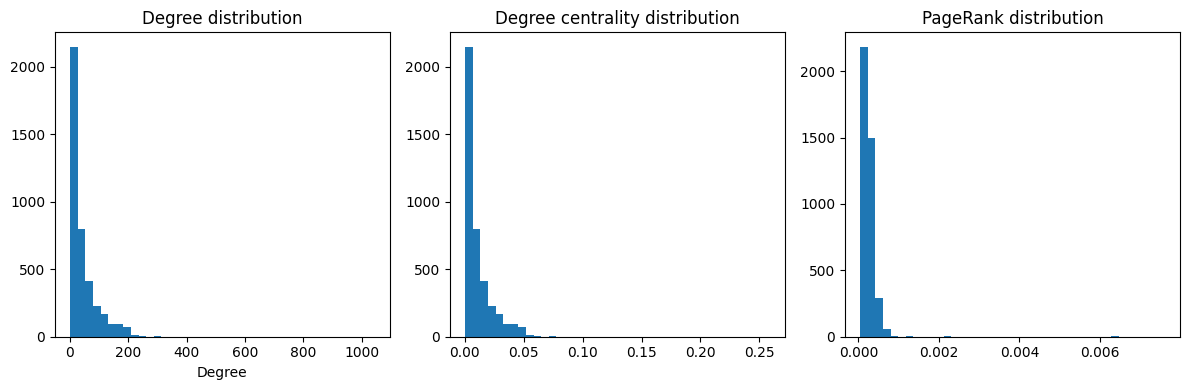

In [25]:
# Plot degree distribution and centrality histograms
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(degrees, bins=40)
plt.title("Degree distribution")
plt.xlabel("Degree")

plt.subplot(1,3,2)
plt.hist(list(deg_cent.values()), bins=40)
plt.title("Degree centrality distribution")

plt.subplot(1,3,3)
plt.hist(list(pr.values()), bins=40)
plt.title("PageRank distribution")
plt.tight_layout()
plt.show()

## 5) Clustering & triangles

Compute clustering coefficients and triangle counts.

In [26]:
avg_clust = nx.average_clustering(G)
clust = nx.clustering(G)
triangles = sum(nx.triangles(G).values()) / 3

print("Average clustering coefficient:", avg_clust)
print("Total triangles (approx):", triangles)

Average clustering coefficient: 0.6055467186200862
Total triangles (approx): 1612010.0


## 6) Bridges & articulation points

Find bridges (edges whose removal increases number of components) and articulation points.

In [27]:
# Bridges
try:
    br = list(nx.bridges(G))
    print("Number of bridges found:", len(br))
    if len(br) > 0:
        print("Example bridges (first 10):", br[:10])
except Exception as e:
    print("Bridge computation failed (graph might be not undirected or too large).", e)

# Articulation points (cut nodes)
try:
    cuts = list(nx.articulation_points(G))
    print("Articulation points found:", len(cuts))
    print("Example articulation points:", cuts[:10])
except Exception as e:
    print("Articulation points computation failed:", e)

Number of bridges found: 75
Example bridges (first 10): [(0, 11), (0, 12), (0, 15), (0, 18), (0, 37), (0, 43), (0, 74), (0, 114), (0, 209), (0, 210)]
Articulation points found: 11
Example articulation points: [686, 698, 3437, 1912, 1684, 3980, 594, 414, 107, 348]


## 7) Assortativity

Degree assortativity coefficient indicates preference for nodes to attach to others with similar degree.

In [28]:
assortativity = nx.degree_assortativity_coefficient(G)
print("Degree assortativity coefficient:", assortativity)

Degree assortativity coefficient: 0.06357722918564943


## 8) Community detection

Apply label propagation and fluid communities (as examples). For very large graphs, apply on a sample or LCC.

In [29]:
from networkx.algorithms import community

# Label propagation
try:
    lp_communities = list(community.label_propagation_communities(LCC))
    print("Label propagation — number of communities (LCC):", len(lp_communities))
except Exception as e:
    print("Label propagation failed:", e)

# Fluid communities: requires specifying number of communities k (choose k based on heuristics or desired granularity)
k = 8
if LCC.number_of_nodes() >= k:
    try:
        fluid_comms = list(community.asyn_fluidc(LCC, k=k, seed=0))
        print("Fluid communities found (k={}):".format(k), len(fluid_comms))
    except Exception as e:
        print("Fluid communities failed:", e)
else:
    print("LCC too small for fluid communities with k =", k)

Label propagation — number of communities (LCC): 44
Fluid communities found (k=8): 8


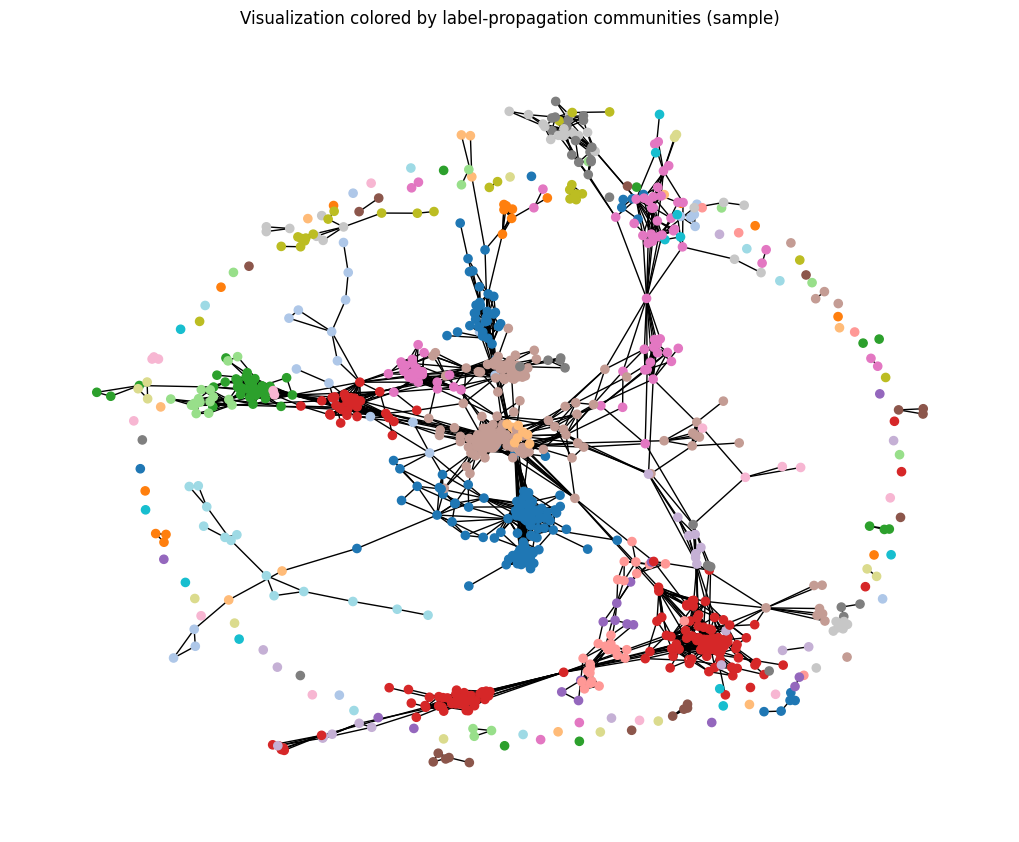

In [30]:
# Visualize communities for the visualization subgraph (G_vis)
try:
    # Build mapping from node -> community id (using label propagation on G_vis if needed)
    lp_vis = list(community.label_propagation_communities(G_vis))
    comm_map = {}
    for i, com in enumerate(lp_vis):
        for node in com:
            comm_map[node] = i
    node_colors = [comm_map.get(n, -1) for n in G_vis.nodes()]
    plt.figure(figsize=(10,8))
    nx.draw(G_vis, pos=pos, node_size=35, node_color=node_colors, cmap=plt.cm.tab20, with_labels=False)
    plt.title("Visualization colored by label-propagation communities (sample)")
    plt.axis('off')
    plt.show()
except Exception as e:
    print('Community visualization failed:', e)